In [12]:
# Basic tools
import os
import sys

# Data tools
import numpy as np
import pandas as pd
import scipy.spatial.distance as sdist
from scipy.stats import norm

# Viz tools
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns

# NLP tools
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.models import Word2Vec, KeyedVectors
from gensim.corpora.wikicorpus import WikiCorpus
import spacy
snlp = spacy.load('en_core_web_sm')

# Local
## Allow local relative imports
module_path = os.path.abspath('..')
include_path = os.path.join(module_path, 'include')
data_path = os.path.join(module_path, 'data')
if include_path not in sys.path:
    sys.path.append(include_path)
from my_nlp import Tokenizer

In [4]:
links_df = pd.read_csv(data_path + '/clickstream-enwiki-2018-08.tsv', sep = '\t')
bilinks_df = pd.read_csv(data_path + '/clickstream-enwiki-2018-08-bilinks.tsv', sep = '\t')
sent_df = pd.read_csv(data_path + '/clickstream-enwiki-2018-08-sentences.tsv', sep = '\t')

In [7]:
sent_df.columns

Index(['origin_title', 'target_title', 'n_clicks_forward', 'n_clicks_backward',
       'origin_p_count', 'origin_newline_count', 'origin_sent_count',
       'n_links_forward', 'target_p_count', 'target_newline_count',
       'target_sent_count', 'n_links_backward', 'origin_p_pos',
       'origin_newline_pos', 'origin_sent_pos', 'origin_sent',
       'origin_first_sent', 'target_p_pos', 'target_newline_pos',
       'target_sent_pos', 'target_sent', 'target_first_sent', 'match'],
      dtype='object')

/usr/local/anaconda3/envs/insight/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


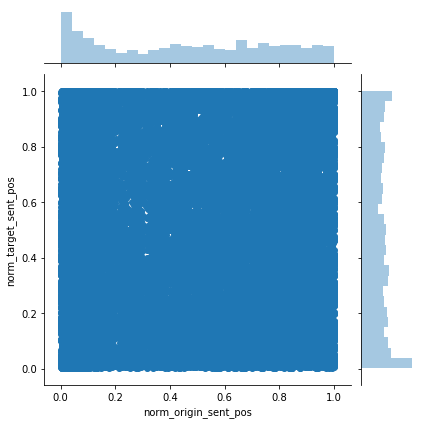

In [16]:
norm_pos_df = sent_df.apply(lambda x: [x['origin_sent_pos'] / x['origin_sent_count'], x['target_sent_pos'] / x['target_sent_count']], axis = 1, result_type = 'expand')
                     .rename(columns = {0: 'norm_origin_sent_pos', 1: 'norm_target_sent_pos'})
sns.jointplot(x = 'norm_origin_sent_pos', y = 'norm_target_sent_pos', data = norm_pos_df);

In [ ]:
links_df[['prev_title', 'curr_title']]

/usr/local/anaconda3/envs/insight/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


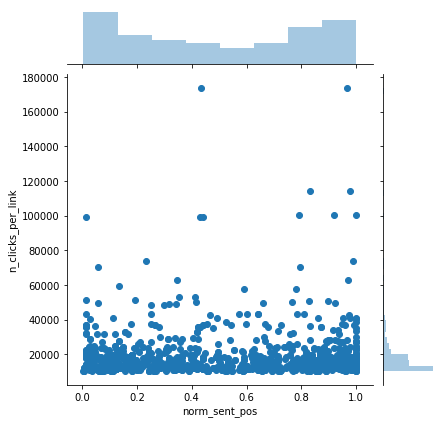

In [55]:
origin_new_columns = dict(zip(['origin_sent_pos', 'origin_sent_count', 'n_clicks_forward'], ['sent_pos', 'sent_count', 'n_clicks']))
target_new_columns = dict(zip(['target_sent_pos', 'target_sent_count', 'n_clicks_backward'], ['sent_pos', 'sent_count', 'n_clicks']))
click_pos_df = pd.concat([sent_df[['origin_sent_pos', 'origin_sent_count', 'n_clicks_forward']].rename(columns = origin_new_columns), sent_df[['target_sent_pos', 'target_sent_count', 'n_clicks_backward']].rename(columns = target_new_columns)], sort = False, ignore_index = True)
click_pos_df['n_links'] = sent_df[['origin_title', 'target_title']].groupby(by = ['origin_title', 'target_title'])['origin_title'].transform('count')
click_pos_df = click_pos_df.apply(lambda x: [x['sent_pos'] / x['sent_count'], x['n_clicks'] / x['n_links']], axis = 1, result_type = 'expand') \
                           .rename(columns = {0: 'norm_sent_pos', 1: 'n_clicks_per_link'})
sns.jointplot(x = 'norm_sent_pos', y = 'n_clicks_per_link', data = click_pos_df.sort_values(by = ['n_clicks_per_link'], ascending = False)[:1000]);

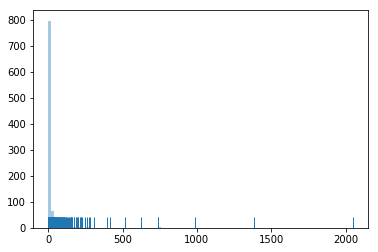

In [64]:
sns.distplot(sent_df[['origin_title', 'target_title']].groupby(by = ['origin_title', 'target_title']).size(), bins = 100, kde=False, rug=True)

In [57]:
sent_df[['origin_title', 'target_title']].groupby(by = ['origin_title', 'target_title']).size()

origin_title                               target_title                                    
2014_Asian_Games                           2010_Asian_Games                                       2
2018_Asia_Cup                              2018_Asia_Cup_Qualifier                                4
2018_FIFA_World_Cup                        2022_FIFA_World_Cup                                    9
2018_in_film                               Avengers:_Infinity_War                                 4
                                           Incredibles_2                                          2
                                           Jurassic_World:_Fallen_Kingdom                         2
2022_FIFA_World_Cup                        2026_FIFA_World_Cup                                    8
2024_Summer_Olympics                       2028_Summer_Olympics                                   6
60_metres                                  Sprint_(running)                                       2
6ix9ine 